# Multiagent Negotiation applied to image segmentators


In [1]:
import os
from io import BytesIO
import tarfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

In [23]:
# This is the neural network model running on each agent
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(images, seg_maps):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, len(seg_maps)+1, width_ratios=[6 for i in seg_maps] + [1])
    for i in range(len(seg_maps)):
        image=images[i]
        seg_map=seg_maps[i]
        plt.subplot(grid_spec[i])
        plt.imshow(image)
        seg_image = label_to_color_image(seg_map).astype(np.uint8)
        plt.imshow(seg_image, alpha=0.7)
        plt.axis('off')
        plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[len(seg_maps)])
    plt.imshow(
        FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [3]:
#@title Select and download models {display-mode: "form"}
MODELS = []
def download_models():    
    _DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
    model_dir = '../models/'
    _MODEL_URLS = {
        'mobilenetv2_coco_voctrainaug':
            'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
        'mobilenetv2_coco_voctrainval':
            'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
        'xception_coco_voctrainaug':
            'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
        'xception_coco_voctrainval':
            'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
    }
    for model, tarname in _MODEL_URLS.items():
        download_path = os.path.join(model_dir, tarname)
        if not os.path.isfile(download_path):
            print('downloading {}, this might take a while...'.format(model))
            urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[model],
                               download_path)
            print('download completed! loading DeepLab model...')
        else:
            print("model already present at {}".format(download_path))
        MODEL = DeepLabModel(download_path)
        MODELS.append(MODEL)
        print('model loaded successfully!')
        
download_models()

model already present at ../models/deeplabv3_pascal_train_aug_2018_01_04.tar.gz
model loaded successfully!
model already present at ../models/deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz
model loaded successfully!
model already present at ../models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz
model loaded successfully!
model already present at ../models/deeplabv3_pascal_trainval_2018_01_04.tar.gz
model loaded successfully!


## Run on sample images

Select one of sample images (leave `IMAGE_URL` empty) or feed any internet image
url for inference.

Note that we are using single scale inference in the demo for fast computation,
so the results may slightly differ from the visualizations in
[README](https://github.com/tensorflow/models/blob/master/research/deeplab/README.md),
which uses multi-scale and left-right flipped inputs.

running deeplab on image https://farm5.staticflickr.com/4040/4603027543_d1fa0e6091_n.jpg...


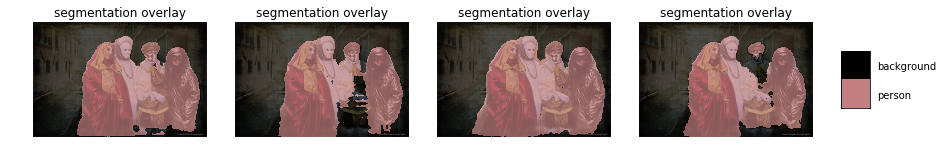

running deeplab on image http://farm5.static.flickr.com/4817/33006739938_e454ef44e8_m.jpg...


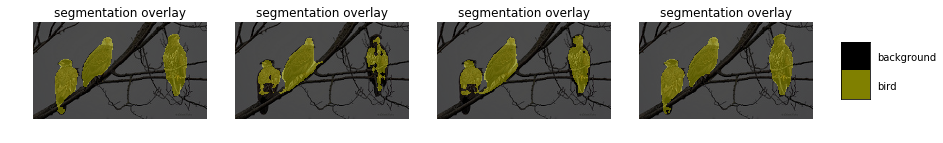

running deeplab on image http://farm5.static.flickr.com/4839/33041584658_2a68f4aebf_m.jpg...


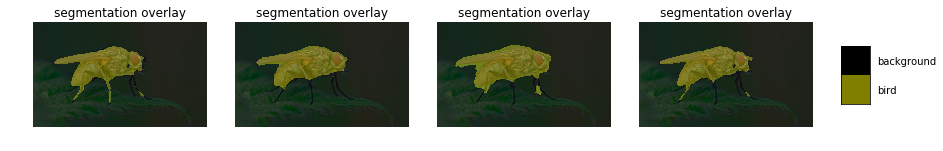

running deeplab on image http://farm8.static.flickr.com/7890/46178108644_16a9e65c74_m.jpg...


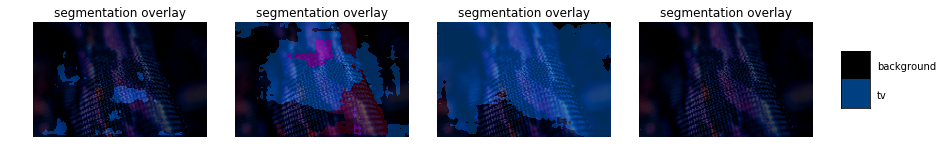

running deeplab on image http://farm8.static.flickr.com/7920/47425338881_de208df2ff_m.jpg...


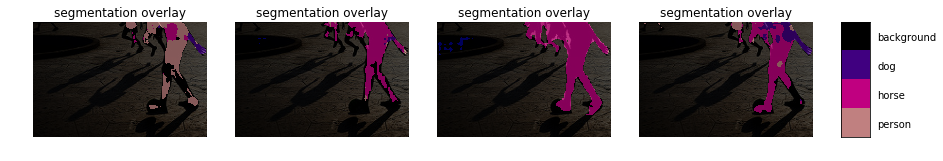

running deeplab on image http://farm8.static.flickr.com/7876/40454860463_0d724135dc_m.jpg...


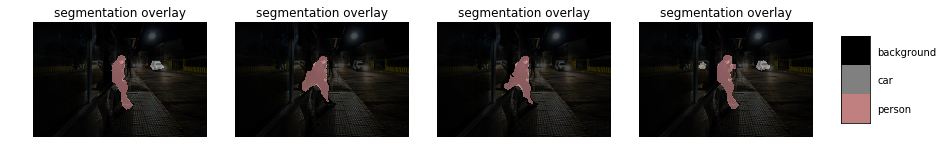

running deeplab on image http://farm8.static.flickr.com/7485/16150577905_a34f7acdb2_m.jpg...


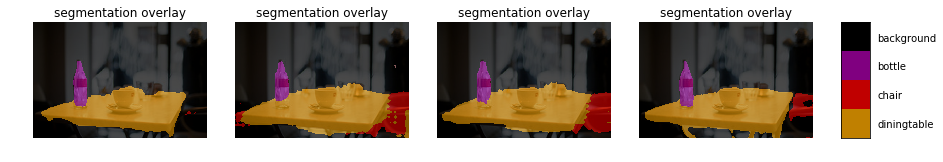

In [34]:
#@title Run on sample images {display-mode: "form"}


image_urls = ['https://farm5.staticflickr.com/4040/4603027543_d1fa0e6091_n.jpg',
             'http://farm5.static.flickr.com/4817/33006739938_e454ef44e8_m.jpg',
             'http://farm5.static.flickr.com/4839/33041584658_2a68f4aebf_m.jpg',
             'http://farm8.static.flickr.com/7890/46178108644_16a9e65c74_m.jpg',
             'http://farm8.static.flickr.com/7920/47425338881_de208df2ff_m.jpg',
             'http://farm8.static.flickr.com/7876/40454860463_0d724135dc_m.jpg',
             'http://farm8.static.flickr.com/7485/16150577905_a34f7acdb2_m.jpg']

def run_visualization(url):
    """Inferences DeepLab model and visualizes result."""
    try:
        f = urllib.request.urlopen(url)
        jpeg_str = f.read()
        original_im = Image.open(BytesIO(jpeg_str))
    except IOError:
        print('Cannot retrieve image. Please check url: ' + url)
        return
    print('running deeplab on image %s...' % url)
    images, seg_maps = list(), list()
    for model in MODELS:
        resized_im, seg_map = model.run(original_im)
        images.append(resized_im)
        seg_maps.append(seg_map)
    vis_segmentation(images, seg_maps)
    return images, seg_map
results = [run_visualization(url) for url in image_urls]


In [39]:
for img_result, seg_results in results:
    for segm in seg_results:
        print(segm.shape)
        
        

(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)
(513,)